## Import python Library

In [2]:
import cv2
import numpy as np
from sklearn.svm import SVR
import scipy.io
import h5py 

## Load sample images

In [3]:
img1 = cv2.imread('/Users/kunal/Desktop/Live Database/databaserelease2/fastfading/img35.bmp',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('/Users/kunal/Desktop/Live Database/databaserelease2/refimgs/bikes.bmp',cv2.IMREAD_GRAYSCALE)
print(img1.shape)

(512, 768)


# Loading dmos  file (subjective score)

In [4]:
mat = scipy.io.loadmat('/Users/kunal/Desktop/Live Database/dmos.mat')
type(mat)
subjective_score = mat["dmos"]
print((subjective_score[0][808],subjective_score[0][809],subjective_score[0][810]))
dmos = mat["dmos"][0]
print(dmos)


(60.20396230395742, 58.27823032567312, 56.94935356368719)
[ 0.         28.00384536 34.01073628 65.13140971 68.9113403  65.15010253
 54.39726604 44.3971449   0.         47.43001376  0.         41.41249842
 49.58114314 48.84324745 26.13791358  0.         62.4787039  37.59887641
 19.96662226  0.         32.69469884  0.         41.92234749  0.
  0.         25.34100954 50.83957042 66.46194644 61.41371717 69.29851566
 33.27987228 70.19193144 53.84629978 23.2929013   0.          0.
 35.02681669 62.90035885 35.77898515 69.87055816 47.53287131 54.86002883
 64.16748928 67.00586811 68.78335868 67.97348673 50.54857713 70.9612236
 26.67330249  0.         31.35996618 52.45539931 60.60039324  0.
 49.04623821 45.83052554  0.         21.24474003 24.26413611 61.17839966
 32.09558699 21.7373924  37.97355042  0.         74.71223055  0.
  0.         34.49728357 21.3314339   0.         72.81703406  0.
  0.         53.34011511 25.03062048  0.         25.98402652 38.46900883
 72.09944236 31.49196891 48.341167

# Function to create feature vector of size 512 

In [5]:
 def feature_extract(img_reference,img_distored):
    u,s,v = np.linalg.svd(img_reference)
    u1,s1,v1 = np.linalg.svd(img_distored)
    alpha = np.multiply(u,u1).sum(axis=0)
    beta = np.multiply(v,v1).sum(axis=0)
    len = min(img_distored.shape[0],img_distored.shape[1])
    fea = alpha[:len] + beta[:len]
    feature_vec = np.zeros(800)
    feature_vec[0:fea.size] = fea
    fea = feature_vec[0:512]
    return fea

## Extract feature for testing on above images and initializing the input X and Label Y

In [6]:
featur = feature_extract(img1,img2)

print(type(featur))

print(featur.shape)

files = open("/Users/kunal/Desktop/Live Database/databaserelease2/main_info.txt", "r")
X = np.array([featur])    ## feature vector act as input and dmos value act as label for training SVM
print(X.shape,"X")
print(type(X),"Xtype")
Y = np.array([2])
print(type(Y))
print(Y)


<class 'numpy.ndarray'>
(512,)
(1, 512) X
<class 'numpy.ndarray'> Xtype
<class 'numpy.ndarray'>
[2]


# Creating feature vector of all images

In [7]:


i = 0
for line in files:
    s = line
    if(i < 227):   
        k= 0
        img_name = '/Users/kunal/Desktop/Live Database/databaserelease2/jp2k/' + s.split()[1]
    if(226<i < 460):   
        k=227
        img_name = '/Users/kunal/Desktop/Live Database/databaserelease2/jpeg/' + s.split()[1]
    if(459<i < 634):   
        k=460
        img_name = '/Users/kunal/Desktop/Live Database/databaserelease2/wn/' + s.split()[1]
    if(633 < i < 808):   
        k=634
        img_name = '/Users/kunal/Desktop/Live Database/databaserelease2/gblur/' + s.split()[1]
    if(807<i < 982):   
        k=808
        img_name = '/Users/kunal/Desktop/Live Database/databaserelease2/fastfading/' + s.split()[1]    
    
    ori_img_names  = '/Users/kunal/Desktop/Live Database/databaserelease2/refimgs/' + s.split()[0]
    stri  = s.split()[1]
    index = int(stri[3:int(stri.find("."))])     
    original_img = cv2.imread(ori_img_names,cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
    
    featurer = feature_extract(original_img,img)
    
    X = np.concatenate((X,np.array([featurer])), axis = 0)
    Y = np.concatenate((Y,np.array([dmos[k+index-1]])),axis = 0)
    
    i = i+1
        
X = X[1:,:]    
print(X.shape) 



(982, 512)


In [8]:
print(X.shape) 
Y = Y[1:] 
print(type(Y))

(982, 512)
<class 'numpy.ndarray'>


# Regression using SVR 

In [11]:
import numpy as np
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

y = Y.T


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=117)

print(X_train.shape)
print(y_train.shape)

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.01)

y_rbf = svr_rbf.fit(X_train, y_train)
corr_vector_svr = np.zeros(10)
for p in range(10):
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y, test_size=0.2, random_state=(p+1)*7)
    y_rbf = svr_rbf.fit(X_train, y_train)
    y_predicted_i = y_rbf.predict(X_test_i)
    print("Correlation coffecient of {} th testing sets".format(p))
    print(np.corrcoef(y_test_i,y_predicted_i))
    corr_vector_svr[p] = np.corrcoef(y_test_i,y_predicted_i)[0,1]

print("mean_output_score for SVR is ",corr_vector_svr.mean())

(785, 512)
(785,)
Correlation coffecient of 0 th testing sets
[[1.        0.9932829]
 [0.9932829 1.       ]]
Correlation coffecient of 1 th testing sets
[[1.         0.98961198]
 [0.98961198 1.        ]]
Correlation coffecient of 2 th testing sets
[[1.         0.97886017]
 [0.97886017 1.        ]]
Correlation coffecient of 3 th testing sets
[[1.         0.99259773]
 [0.99259773 1.        ]]
Correlation coffecient of 4 th testing sets
[[1.         0.99355822]
 [0.99355822 1.        ]]
Correlation coffecient of 5 th testing sets
[[1.         0.99001786]
 [0.99001786 1.        ]]
Correlation coffecient of 6 th testing sets
[[1.         0.99608132]
 [0.99608132 1.        ]]
Correlation coffecient of 7 th testing sets
[[1.         0.98906032]
 [0.98906032 1.        ]]
Correlation coffecient of 8 th testing sets
[[1.         0.98649397]
 [0.98649397 1.        ]]
Correlation coffecient of 9 th testing sets
[[1.       0.987868]
 [0.987868 1.      ]]
mean_output_score for SVR is  0.989743247963

# regression using Neural Network 

In [12]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

train_data = X_train
test_data = X_test
train_labels = y_train
test_labels = y_test

print("Training set: {}".format(train_data.shape))
print("Testing set:  {}".format(test_data.shape))



mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std



def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
#       keras.layers.Dense(64, activation=tf.nn.relu),
     keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
print(model.summary())



# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


1.10.1
Training set: (785, 512)
Testing set:  (197, 512)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 32,897
Trainable params: 32,897
Non-trainable params: 0
_________________________________________________________________
None

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...................................................................

# analysis training in neural network

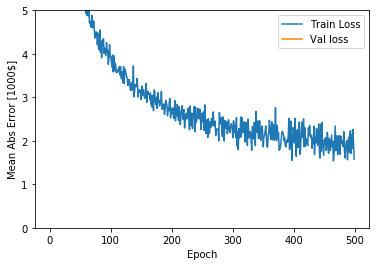

In [13]:
import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 5])

plot_history(history)





# Testing for 10 runs of test data in neural network 

[[1.         0.91814548]
 [0.91814548 1.        ]]
Correlation coffecient of 0 th testing sets
[[1.         0.95251384]
 [0.95251384 1.        ]]
Correlation coffecient of 1 th testing sets
[[1.         0.97568588]
 [0.97568588 1.        ]]
Correlation coffecient of 2 th testing sets
[[1.         0.98584065]
 [0.98584065 1.        ]]
Correlation coffecient of 3 th testing sets
[[1.        0.9922288]
 [0.9922288 1.       ]]
Correlation coffecient of 4 th testing sets
[[1.         0.99643817]
 [0.99643817 1.        ]]
Correlation coffecient of 5 th testing sets
[[1.         0.99671852]
 [0.99671852 1.        ]]
Correlation coffecient of 6 th testing sets
[[1.         0.99815056]
 [0.99815056 1.        ]]
Correlation coffecient of 7 th testing sets
[[1.         0.99642136]
 [0.99642136 1.        ]]
Correlation coffecient of 8 th testing sets
[[1.         0.99797357]
 [0.99797357 1.        ]]
Correlation coffecient of 9 th testing sets
[[1.         0.99688016]
 [0.99688016 1.        ]]
mea

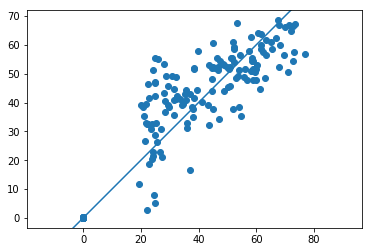

In [14]:
test_predictions = model.predict(test_data).flatten()
print(np.corrcoef(test_labels,test_predictions))
plt.scatter(test_labels, test_predictions)
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

corr_vector_neural = np.zeros(10)
for p in range(10):
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y, test_size=0.2, random_state=(p+1)*7)
    mean = X_train_i.mean(axis=0)
    std = X_train_i.std(axis=0)
    X_train_i = (X_train_i - mean) / std
    X_test_i = (X_test_i - mean) / std
    # Store training stats
    history = model.fit(X_train_i, y_train_i, epochs=EPOCHS,
                    validation_split=0.2, verbose=0)
    y_predicted_i = model.predict(X_test_i).flatten()
    print("Correlation coffecient of {} th testing sets".format(p))
    print(np.corrcoef(y_test_i,y_predicted_i))
    corr_vector_neural[p] = np.corrcoef(y_test_i,y_predicted_i)[0,1]

print("mean_output_score for neural network is ",corr_vector_neural.mean())

# Regression using Logistic Regression

In [15]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

y_train_new = y_train.round()

clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial').fit(X_train, y_train_new)


corr_vector_logistic = np.zeros(10)
for p in range(10):
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y, test_size=0.2, random_state=(p+1)*7)
    mean = X_train_i.mean(axis=0)
    std = X_train_i.std(axis=0)
    X_train_i = (X_train_i - mean) / std
    X_test_i = (X_test_i - mean) / std
    clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial').fit(X_train, y_train_new)
    y_predicted_i = predicty = clf.predict(X_test_i)
    
    print("Correlation coffecient of {} th testing sets".format(p))
    print(np.corrcoef(y_test_i,y_predicted_i))
    corr_vector_logistic[p] = np.corrcoef(y_test_i,y_predicted_i)[0,1]

print("mean_output_score for logistic regression is ",corr_vector_logistic.mean())

Correlation coffecient of 0 th testing sets
[[1.         0.76639282]
 [0.76639282 1.        ]]
Correlation coffecient of 1 th testing sets
[[1.         0.77177464]
 [0.77177464 1.        ]]
Correlation coffecient of 2 th testing sets
[[1.        0.7545642]
 [0.7545642 1.       ]]
Correlation coffecient of 3 th testing sets
[[1.         0.82417921]
 [0.82417921 1.        ]]
Correlation coffecient of 4 th testing sets
[[1.         0.83159881]
 [0.83159881 1.        ]]
Correlation coffecient of 5 th testing sets
[[1.         0.79911208]
 [0.79911208 1.        ]]
Correlation coffecient of 6 th testing sets
[[1.         0.75480234]
 [0.75480234 1.        ]]
Correlation coffecient of 7 th testing sets
[[1.         0.77097646]
 [0.77097646 1.        ]]
Correlation coffecient of 8 th testing sets
[[1.         0.76589316]
 [0.76589316 1.        ]]
Correlation coffecient of 9 th testing sets
[[1.        0.7787515]
 [0.7787515 1.       ]]
mean_output_score for logistic regression is  0.7818045224

## comparison of three models 

all the models give good accuracy in terms of PLCC. SVR and neural network perform almost equally but logistic regression is not that good . logistic regression uses 100 classes to classify the dataset images whereas neural network and SVR does regression. neural network with 1 hidden layer(64 units) works fine. All the parameter are tuned to give maximum accuracy.